This notebook replaces the final step of the GPI DRP when reducing pol data: gpi_combine_polarization_sequence

In [1]:
from pyMuellerMat import common_mms as cmm
from pyMuellerMat import MuellerMat
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from scipy.optimize import least_squares

#Some nicer printing options to avoid machine errors
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

First some properties of GPI: These are offsets taken from the GPI DRP that give the zero-point of the HWP 
and give the rotation between the instrument and the sky frame 

In [2]:
## These get used below
hwp_offset = -29.14 #Degrees
sky_offset = 90-18.5 #Degrees

Now we set up our instrument model. In the future I hope to make a GPI_HWP object, but for now we implement the HWP as a retarder with a retardance take from the GPI DRP. If working in J-band, comment out the H-band line and uncomment the J-band line. 

In [3]:
wollaston_mm = cmm.WollastonPrism()
hwp_mm = cmm.Retarder() 
sky_mm = cmm.Rotator()

sys_mm = MuellerMat.SystemMuellerMatrix([wollaston_mm,hwp_mm,sky_mm])

#Set the HWP retardance
sys_mm.master_property_dict['Retarder']['phi'] = 2*np.pi*0.4819#Assuming H-band
# sys_mm.master_property_dict['Retarder']['phi'] = 2*np.pi*0.4863#Assuming J-band

### Read in the files - Here add in your own file list

In [4]:
filelist = sorted(glob.glob("/Users/maxwellmb/Data/GPI/Reduced/131212/*distorcorr*.fits"))

In [5]:
# A bunch of empty ararys - with descriptions of what they will be. 
pas = np.zeros(len(filelist)) #The parallactic angles (with the GPI offset correction)
hwps = np.zeros(len(filelist)) #The HWPs (with the GPI offset correction)
data = np.zeros([2*len(filelist),281,281]) #All the podc slices
measurement_matrix = np.zeros([2*len(filelist),4]) #The measurement matrix
stokes_cube = np.zeros([4,281,281]) #The Stokes cube determined through an interative solver with a loss function
stokes_cube_lstsq = np.zeros([4,281,281]) #The Stokes cube

In [6]:
#Fill up the arrays
for i,filename in enumerate(filelist):
    with fits.open(filename) as hdu:
        pas[i] = hdu[1].header['AVPARANG']+sky_offset #Applying the offset like in the GPI DRP
        hwps[i] = -((hdu[0].header['WPANGLE'])-(hwp_offset)) #Applying the offset and sign convention like in the GPI DRP
        data[i*2,:,:] = hdu[1].data[0,:,:]
        data[i*2+1,:,:] = hdu[1].data[1,:,:]  

In [7]:
#Build up the measurement matrix based on the HWP position and PA
for i,filename in enumerate(filelist):
    #The 'ordinary' beam
    sys_mm.master_property_dict['WollastonPrism']['beam'] = 'o'
    sys_mm.master_property_dict['Retarder']['theta'] = hwps[i]
    sys_mm.master_property_dict['Rotator']['pa'] = pas[i]
    measurement_matrix[i*2] = sys_mm.evaluate()[0]

    #The 'extraordinary beam'
    sys_mm.master_property_dict['WollastonPrism']['beam'] = 'e'
    sys_mm.master_property_dict['Retarder']['theta'] = hwps[i]
    sys_mm.master_property_dict['Rotator']['pa'] = pas[i]
    measurement_matrix[i*2+1] = sys_mm.evaluate()[0]

In [8]:
#The function to minimize for the interative solver
def to_minimize(stokes,data):
    return (data-(measurement_matrix@stokes))

## Here we do the inversion for each pixel. For now this example still includes the instrumental polarization. 

In [9]:
#Cycle through all the pixels

#Ok well here I'm only going to care about an inner chunk in order to 
for i in np.arange(80,200):
    for j in np.arange(80,200):

        this_pixel = data[:,i,j]
        if any(np.isnan(data[:,i,j])):
            stokes_cube[:,i,j] = np.nan
        else:
            #This version just does the simple linear inversion and is most similar to the GPI pipeline
            stokes_cube_lstsq[:,i,j] = np.linalg.lstsq(measurement_matrix,this_pixel)[0]
            
            #This version tries to include a loss function and solve iteratively. It takes longer. 
            #We take the starting guess as the result of the linear inversion
            #So far I haven't gotten any better results with this. 
 
#             result = least_squares(to_minimize,stokes_cube_lstsq[:,i,j],args=([this_pixel]),method='trf',
#                                    loss='linear',ftol=1e-12,xtol=1e-12,gtol=1e-20,
#                                   x_scale=[100,0.1,0.1,0.1],
#                                   max_nfev=10000)
#             stokes_cube[:,i,j]=result.x

/Users/maxwellmb/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


Text(0.5, 0.98, 'Normal Linear Inversion')

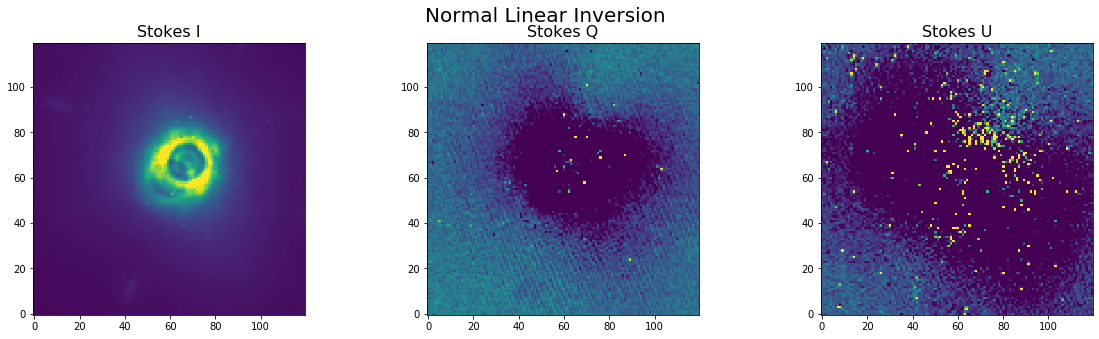

In [10]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
axes[0].imshow(stokes_cube_lstsq[0][80:200,80:200],vmin=74,vmax=31000,origin='lower')
axes[1].imshow(stokes_cube_lstsq[1][80:200,80:200],vmin=-20,vmax=20,origin='lower')
axes[2].imshow(stokes_cube_lstsq[2][80:200,80:200],vmin=-20,vmax=20,origin='lower')
# axes[3].imshow(stokes_cube_lstsq[3][80:200,80:200],vmin=-100,vmax=100,origin='lower')
axes[0].set_title("Stokes I",fontsize=16)
axes[1].set_title("Stokes Q",fontsize=16)
axes[2].set_title("Stokes U",fontsize=16)
fig.suptitle("Normal Linear Inversion",fontsize=20)

Text(0.5, 0.98, 'Linear Inversion with Loss Function')

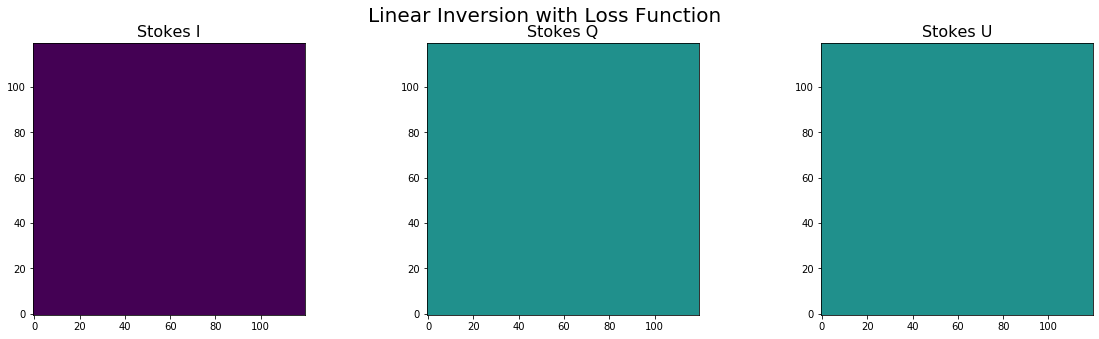

In [11]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
axes[0].imshow(stokes_cube[0][80:200,80:200],vmin=74,vmax=31000,origin='lower')
axes[1].imshow(stokes_cube[1][80:200,80:200],vmin=-20,vmax=20,origin='lower')
axes[2].imshow(stokes_cube[2][80:200,80:200],vmin=-20,vmax=20,origin='lower')
# axes[3].imshow(stokes_cube[3][80:200,80:200],vmin=-100,vmax=100,origin='lower')
axes[0].set_title("Stokes I",fontsize=16)
axes[1].set_title("Stokes Q",fontsize=16)
axes[2].set_title("Stokes U",fontsize=16)
fig.suptitle("Linear Inversion with Loss Function",fontsize=20)